In [43]:
# Reference: https://www.youtube.com/watch?v=CbTU92pbDKw&t

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import yfinance as yf

# data = pd.read_csv('AMZN.csv')
data = yf.download("C", start="2010-01-01")
data = data.reset_index()

data

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,33.599998,34.099998,33.400002,34.000000,26.409618,40679350
1,2010-01-05,34.200001,35.500000,34.099998,35.299999,27.419401,66861710
2,2010-01-06,35.599998,36.799999,35.099998,36.400002,28.273832,67433890
3,2010-01-07,36.900002,37.000000,36.099998,36.500000,28.351507,67245190
4,2010-01-08,36.500000,36.700001,35.099998,35.900002,27.885452,62409770
...,...,...,...,...,...,...,...
3611,2024-05-09,62.380001,63.430000,62.290001,63.320000,63.320000,11563000
3612,2024-05-10,63.580002,63.919998,63.119999,63.529999,63.529999,9548700
3613,2024-05-13,63.619999,63.950001,63.369999,63.400002,63.400002,6617900
3614,2024-05-14,63.509998,63.970001,63.230000,63.590000,63.590000,8322500


In [44]:
data = data[['Date', 'Close']]
data

,Date,Close
0,2010-01-04,34.000000
1,2010-01-05,35.299999
2,2010-01-06,36.400002
3,2010-01-07,36.500000
4,2010-01-08,35.900002
...,...,...
3611,2024-05-09,63.320000
3612,2024-05-10,63.529999
3613,2024-05-13,63.400002
3614,2024-05-14,63.590000


In [45]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

C:\Users\isss1\AppData\Local\Temp\ipykernel_19328\1819287010.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


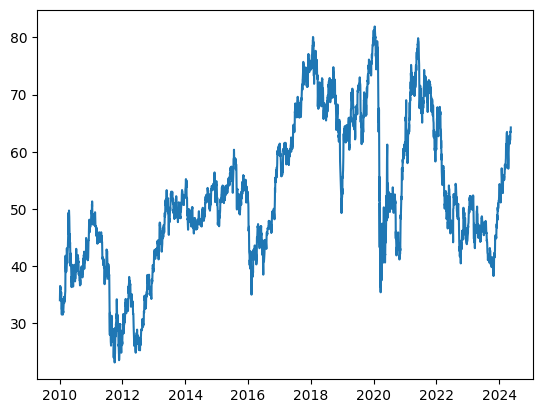

In [46]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [47]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2010-01-13,35.000000,35.200001,36.299999,35.900002,36.500000,36.400002,35.299999,34.000000
2010-01-14,35.099998,35.000000,35.200001,36.299999,35.900002,36.500000,36.400002,35.299999
2010-01-15,34.200001,35.099998,35.000000,35.200001,36.299999,35.900002,36.500000,36.400002
2010-01-19,35.400002,34.200001,35.099998,35.000000,35.200001,36.299999,35.900002,36.500000
2010-01-20,34.599998,35.400002,34.200001,35.099998,35.000000,35.200001,36.299999,35.900002
...,...,...,...,...,...,...,...,...
2024-05-09,63.320000,62.750000,62.000000,62.810001,61.520000,61.540001,61.349998,61.330002
2024-05-10,63.529999,63.320000,62.750000,62.000000,62.810001,61.520000,61.540001,61.349998
2024-05-13,63.400002,63.529999,63.320000,62.750000,62.000000,62.810001,61.520000,61.540001


In [48]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[35.        , 35.20000076, 36.29999924, ..., 36.40000153,
        35.29999924, 34.        ],
       [35.09999847, 35.        , 35.20000076, ..., 36.5       ,
        36.40000153, 35.29999924],
       [34.20000076, 35.09999847, 35.        , ..., 35.90000153,
        36.5       , 36.40000153],
       ...,
       [63.40000153, 63.52999878, 63.31999969, ..., 62.81000137,
        61.52000046, 61.54000092],
       [63.59000015, 63.40000153, 63.52999878, ..., 62.        ,
        62.81000137, 61.52000046],
       [64.23999786, 63.59000015, 63.40000153, ..., 62.75      ,
        62.        , 62.81000137]])

In [49]:
shifted_df_as_np.shape

(3609, 8)

In [50]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.59557827, -0.58877553, -0.55136061, ..., -0.54795918,
        -0.58537422, -0.62959188],
       [-0.59217696, -0.59557827, -0.58877553, ..., -0.54455787,
        -0.54795918, -0.58537422],
       [-0.62278913, -0.59217696, -0.59557827, ..., -0.56496598,
        -0.54455787, -0.54795918],
       ...,
       [ 0.37040812,  0.3748298 ,  0.36768697, ...,  0.35034009,
         0.30646251,  0.3071428 ],
       [ 0.37687066,  0.37040812,  0.3748298 , ...,  0.32278903,
         0.35034009,  0.30646251],
       [ 0.39897943,  0.37687066,  0.37040812, ...,  0.34829923,
         0.32278903,  0.35034009]])

In [51]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((3609, 7), (3609,))

In [52]:
X = dc(np.flip(X, axis=1))
X

array([[-0.62959188, -0.58537422, -0.54795918, ..., -0.56496598,
        -0.55136061, -0.58877553],
       [-0.58537422, -0.54795918, -0.54455787, ..., -0.55136061,
        -0.58877553, -0.59557827],
       [-0.54795918, -0.54455787, -0.56496598, ..., -0.58877553,
        -0.59557827, -0.59217696],
       ...,
       [ 0.3071428 ,  0.30646251,  0.35034009, ...,  0.34829923,
         0.36768697,  0.3748298 ],
       [ 0.30646251,  0.35034009,  0.32278903, ...,  0.36768697,
         0.3748298 ,  0.37040812],
       [ 0.35034009,  0.32278903,  0.34829923, ...,  0.3748298 ,
         0.37040812,  0.37687066]])

In [53]:
split_index = int(len(X) * 0.95)

split_index

3428

In [54]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3428, 7), (181, 7), (3428,), (181,))

In [55]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3428, 7, 1), (181, 7, 1), (3428, 1), (181, 1))

In [56]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([3428, 7, 1]),
 torch.Size([181, 7, 1]),
 torch.Size([3428, 1]),
 torch.Size([181, 1]))

In [57]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [58]:
train_dataset

In [59]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [60]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [61]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [62]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [63]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [64]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.386
Batch 200, Loss: 0.213

Val Loss: 0.060
***************************************************

Epoch: 2
Batch 100, Loss: 0.109
Batch 200, Loss: 0.039

Val Loss: 0.004
***************************************************

Epoch: 3
Batch 100, Loss: 0.018
Batch 200, Loss: 0.013

Val Loss: 0.004
***************************************************

Epoch: 4
Batch 100, Loss: 0.011
Batch 200, Loss: 0.008

Val Loss: 0.003
***************************************************

Epoch: 5
Batch 100, Loss: 0.007
Batch 200, Loss: 0.006

Val Loss: 0.002
***************************************************

Epoch: 6
Batch 100, Loss: 0.005
Batch 200, Loss: 0.004

Val Loss: 0.002
***************************************************

Epoch: 7
Batch 100, Loss: 0.004
Batch 200, Loss: 0.003

Val Loss: 0.002
***************************************************

Epoch: 8
Batch 100, Loss: 0.003
Batch 200, Loss: 0.003

Val Loss: 0.001
***************************************************



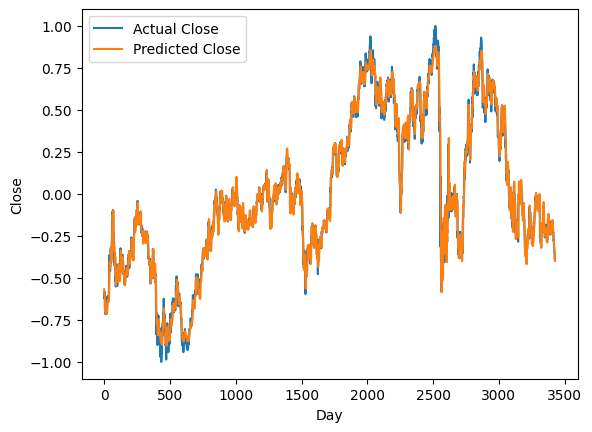

In [65]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [66]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([35.82442896, 35.30425698, 34.91725511, ..., 41.2797378 ,
       41.02022659, 40.78574458])

In [67]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([35.00000058, 35.0999982 , 34.20000034, ..., 41.08000191,
       41.08000191, 41.24000178])

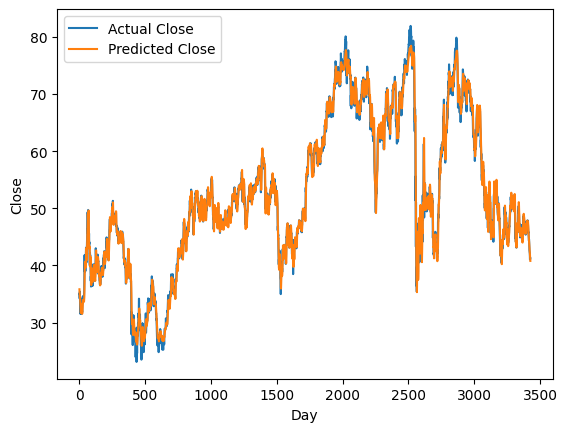

In [68]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [69]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([40.71856985, 40.84923406, 41.21391941, 41.46240817, 41.43882469,
       41.46283575, 41.38196445, 41.31542933, 41.04245637, 40.77941499,
       40.49868601, 40.69317791, 41.34925458, 42.31729899, 43.02896806,
       43.28280507, 43.17609147, 42.69702937, 42.11034155, 41.39061418,
       40.94276716, 40.34048845, 40.03418002, 40.25046098, 40.60972798,
       40.73163995, 40.45189667, 40.10195407, 39.68376427, 39.68710343,
       40.06063916, 40.74879309, 41.33993282, 41.66741609, 41.73112024,
       41.43782758, 41.21466505, 40.75769516, 40.31079355, 39.83790771,
       39.23750141, 38.79927757, 38.41395536, 38.52810167, 38.38744891,
       38.48880637, 38.80481683, 39.10074944, 39.97880843, 41.12490306,
       42.12739305, 42.53639075, 42.54130617, 42.14390219, 41.7811576 ,
       41.97201244, 43.00848978, 44.23066648, 45.13936752, 45.82933341,
       45.9487938 , 45.7052003 , 45.300644  , 45.19995331, 45.11574198,
       44.90292372, 45.1894741 , 45.64201924, 46.49681805, 47.31

In [70]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([41.31999953, 41.72000141, 41.36999922, 41.2900006 , 41.59000047,
       41.36000103, 41.36999922, 40.72999972, 40.58999972, 40.58999972,
       41.6799999 , 42.36999909, 43.13999952, 42.70999871, 42.63999915,
       42.68000065, 42.29999952, 41.70999884, 40.91999853, 41.02000053,
       40.22000117, 40.45999879, 41.20000116, 41.13000072, 40.50000029,
       39.86000079, 39.81000111, 39.88000067, 40.56999985, 40.74000141,
       41.43999878, 41.52999909, 41.52999909, 41.43000059, 40.95000097,
       41.20000116, 40.47000135, 40.06000129, 39.68000017, 38.88999899,
       38.93000049, 38.61000074, 39.34000055, 38.24000131, 38.93000049,
       39.49000136, 39.59999804, 41.34999847, 42.25999802, 42.04000115,
       41.95999903, 41.8199999 , 41.50000016, 42.08000178, 42.70000052,
       44.36000063, 44.88000088, 44.66999782, 45.3600005 , 45.2599985 ,
       45.09000044, 45.02000088, 45.22999956, 45.08000226, 44.86000101,
       45.74999981, 46.09999849, 47.22999974, 47.36999886, 46.70

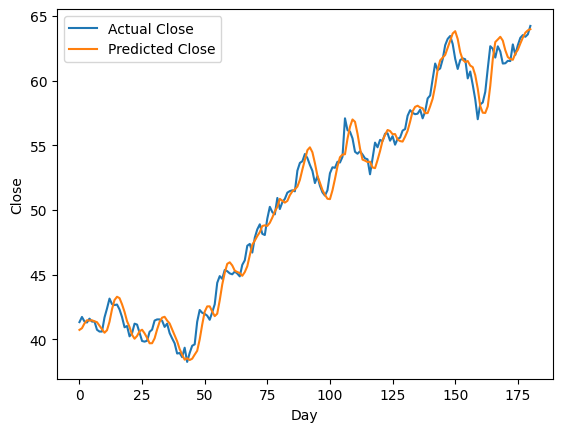

In [71]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
